In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import os,glob,sys
import pylheV
import scipy as sc

sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
particlesDict = {}

In [3]:
with open("particles.xml") as f:
    xmlStr = f.read()
    xmlStr = "<root>\n" + xmlStr[:] + "</root>" 
root = ET.fromstring(xmlStr)

In [4]:
for particle in root:
    particleData  = particle.attrib
    pid = int(particleData['id'])
    particlesDict[pid] = {}
    for attr,val in particle.attrib.items():
        try:
            particlesDict[pid][attr] = eval(val) #Try to evaluate attribute
        except:
            particlesDict[pid][attr] = val

In [5]:
def getKey(my_value,d):    
    return next(key for key, value in d.items() if value == my_value)

In [6]:
def event_selector(nmin = 0, nmax = 1e5, dictionary = {}):
    eventDict = {}
    for key in dictionary:
        if dictionary[key] <= nmax and dictionary[key] >= nmin:
            eventDict[key] = dictionary[key]
        
    return eventDict

In [7]:
#No sort
def dictName1(file_name):
    
    eventDict = {}
    for n,e in enumerate(pylheV.readLHE(file_name)):
        f_ptc = ''
        for ptc in e.particles:
            if ptc.status > 0:
                if ptc.id > 0:
                    f_ptc = f_ptc + particlesDict[ptc.id]['name']
                else:
                    f_ptc = f_ptc + particlesDict[abs(ptc.id)]['antiName']
        if (eventDict.get(f_ptc)) == None:
            eventDict[f_ptc] = 1       
        else:
            eventDict[f_ptc] +=1
    
    return eventDict

In [8]:
def cleaner(f_ptc):
    f_ptc = np.sort(f_ptc)
    final = [f_ptc[0]]
    count = [1]
    j = 0
    for i in range(len(f_ptc)-1):
        if f_ptc[i+1] != f_ptc[i]:
            final.append(f_ptc[i+1])
            count.append(1)
            j+=1
        else:
            count[j] += 1
        
            
    return final, count
            
            


In [9]:
#Neutrinos in the output are given by adding or removing 'and abs(ptc.id) != 12 and abs(ptc.id) != 14 and abs(ptc.id) != 16' after ptc.status > 0
def dictName(file_name):
    
    eventDict = {}
    for n,e in enumerate(pylheV.readLHE(file_name)):
        f_ptc = []
        for ptc in e.particles:
            if ptc.status > 0:
                f_ptc.append(ptc.id)
   
        f_ptc = np.sort(f_ptc)
        f_ptc, count = cleaner(f_ptc)
        final = ''
        for i,f in enumerate(f_ptc):
            if f > 0:
                if count[i] == 1:
                    final = final + particlesDict[f]['name']
                else:
                    final = final + str(count[i]) +  particlesDict[f]['name']
            else:
                if count[i] == 1:
                    final = final + particlesDict[abs(f)]['antiName']
                else:
                    final = final + str(count[i]) +  particlesDict[abs(f)]['antiName']
                
        if (eventDict.get(final)) == None:
            eventDict[final] = 1       
        else:
            eventDict[final] +=1
    
    return eventDict

In [10]:
def dictID(file_name):
    
    eventDict = {}
    
    for n,e in enumerate(pylheV.readLHE(file_name)):
        f_ptc = []
        for ptc in e.particles:
            if ptc.status > 0:
                f_ptc.append(ptc.id)
   
        f_ptc = np.sort(f_ptc)
        f_ptc = tuple(f_ptc)
        
        if f_ptc in eventDict:
            eventDict[f_ptc] += 1
        else:
            eventDict[f_ptc] = 1
        
    
    return eventDict

In [16]:
def final_state(eDict,fstate):
    fstate_frac = [0,0,0]
    for i,dicti in enumerate(eDict):
        fstate_frac[i] = dicti.get(fstate,0)
        fstate_frac[i] = fstate_frac[i]/100000
    return fstate_frac

In [17]:
fName = ['NoPtCut_1GeV.lhe','NoPtCut_1dot5GeV.lhe','NoPtCut_3GeV.lhe']
eDict = []
for file in fName:
    eDict.append(dictName(file))

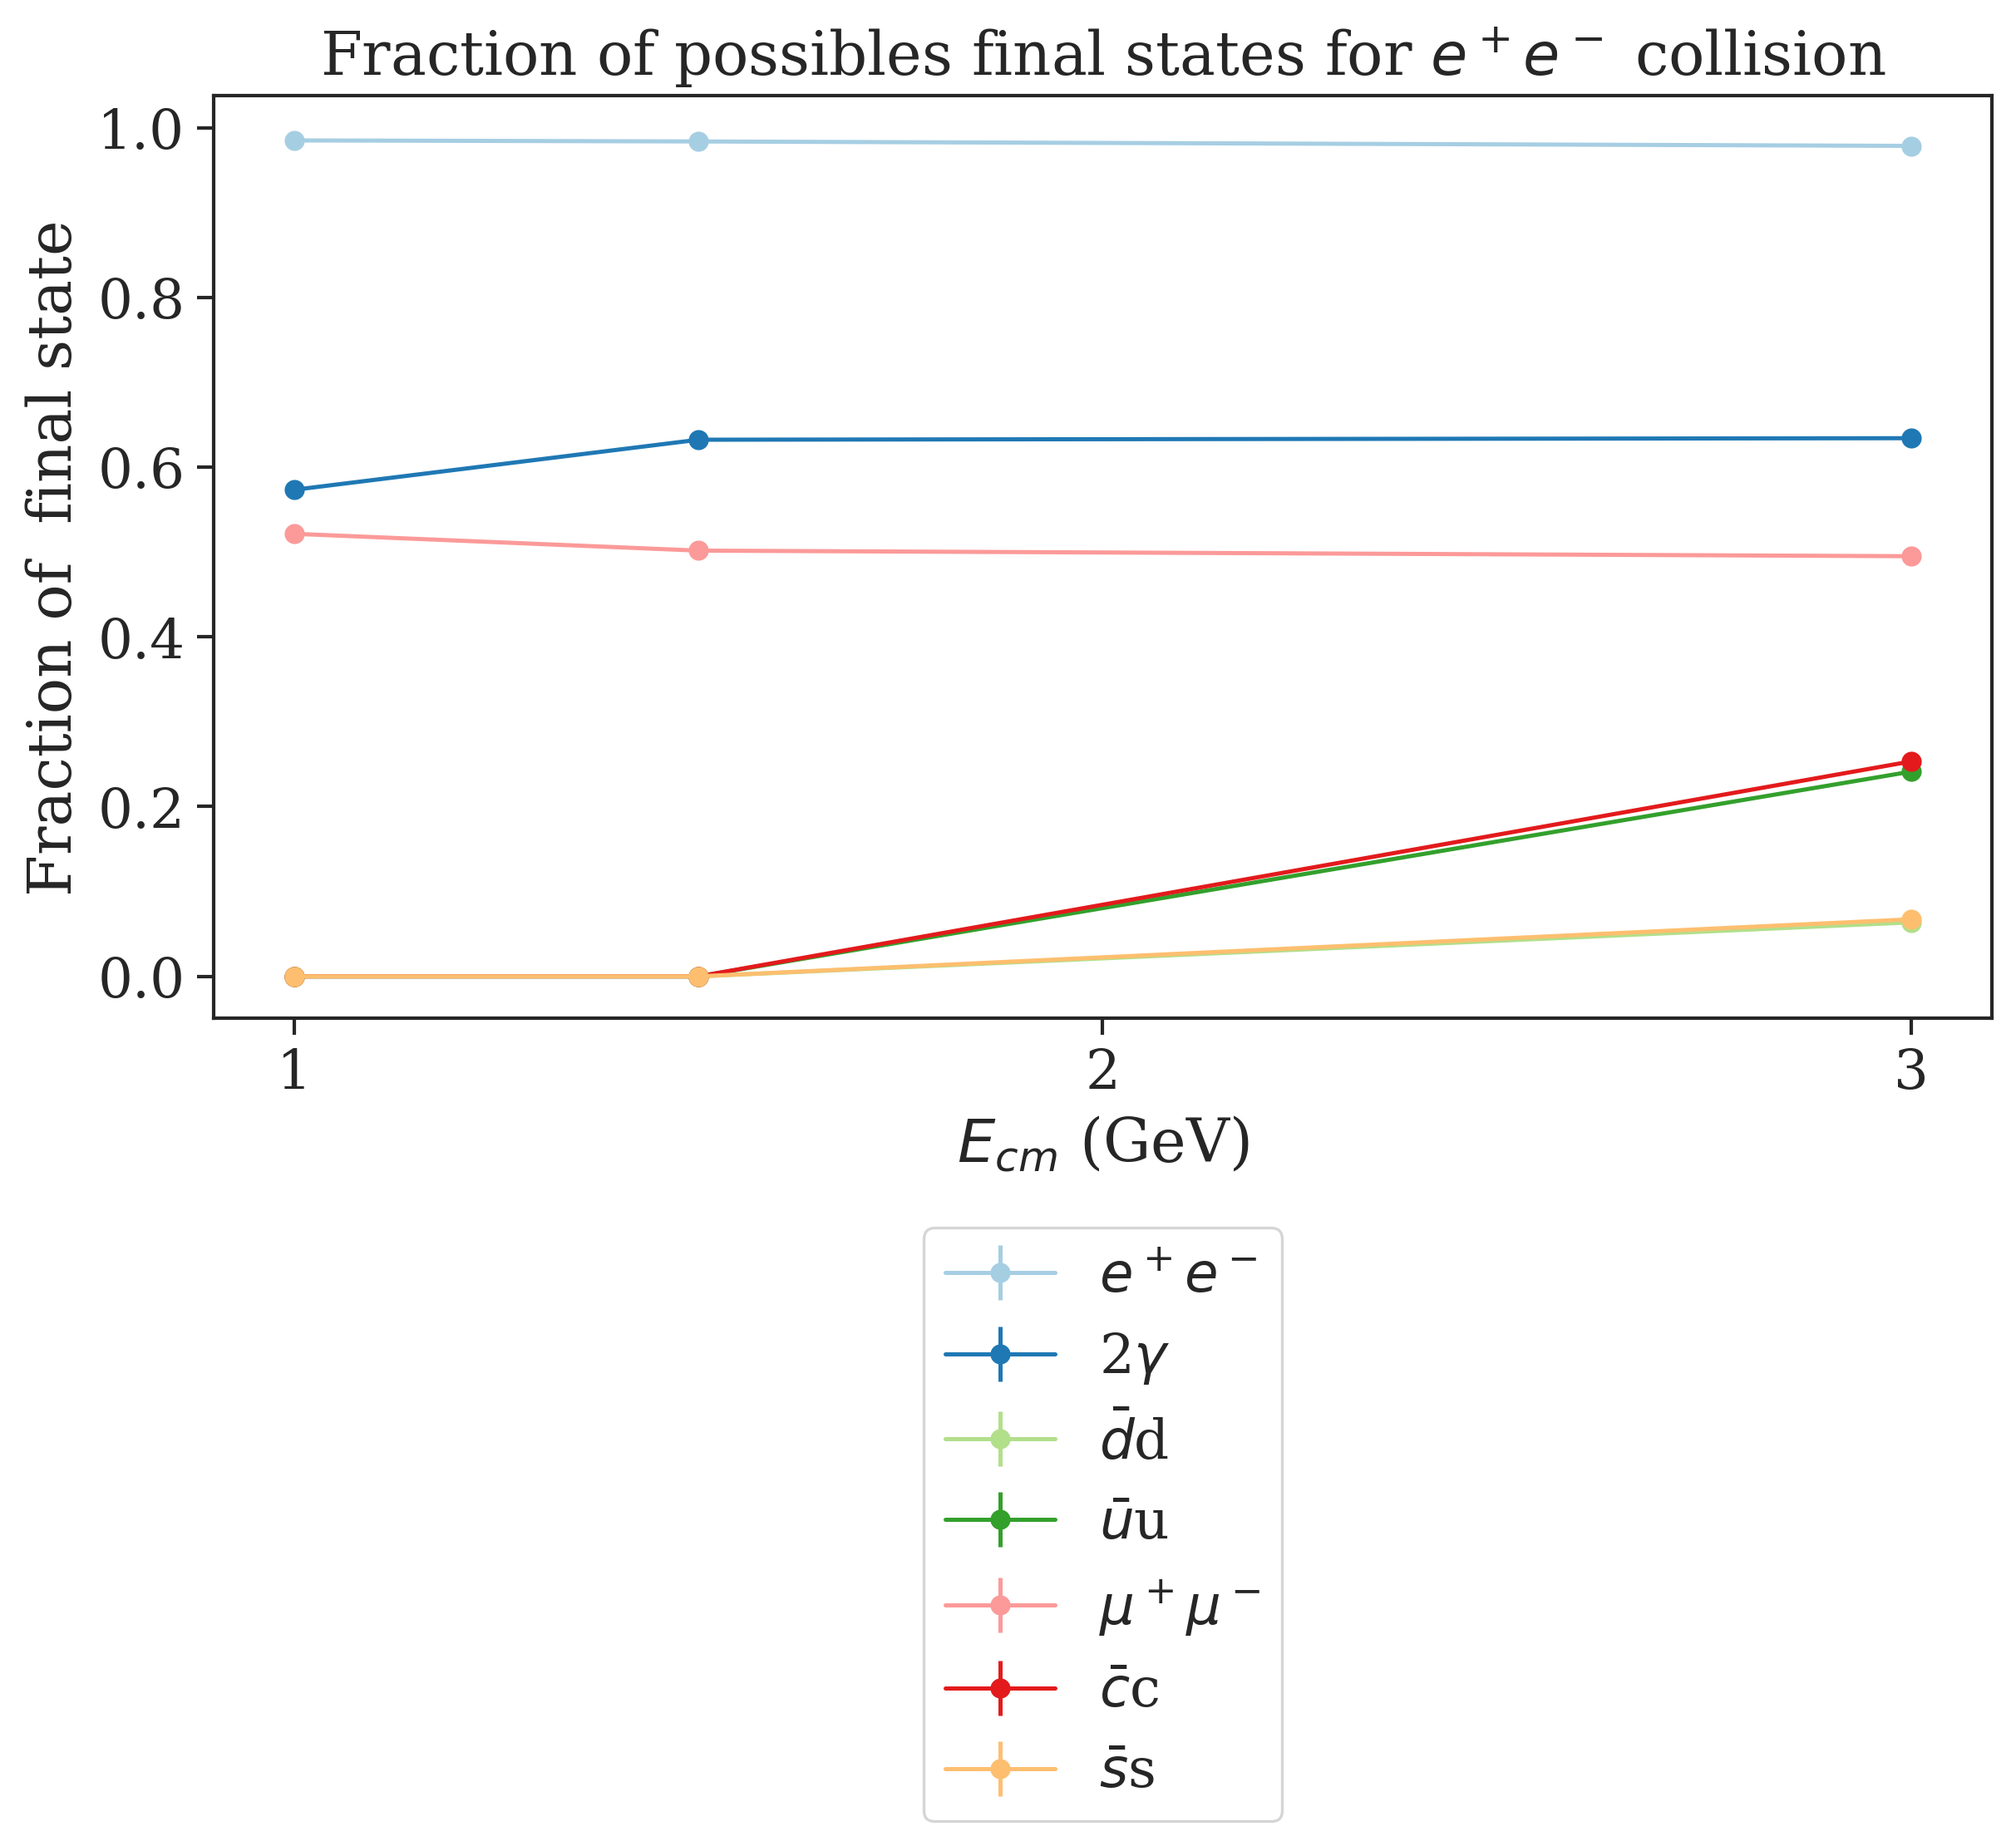

In [22]:
energy = [1,1.5,3]
fig = plt.figure(figsize = [9.2,4.9], dpi = 300)

color = sns.color_palette("Paired",len(eDict[2]))

for i,key in enumerate(eDict[2]):
    if i==0:
        f_state = np.array(final_state(eDict,key))
        plt.errorbar(x = energy,y = f_state, xerr = None, yerr = np.sqrt(f_state/1e5), color = color[i], marker ='o', label = key)
    
    elif key == '2$\\gamma$':
        f_state = np.array(final_state(eDict,key))
        plt.errorbar(x = energy,y = 45*f_state, xerr = None, yerr = np.sqrt(f_state/1e5), color = color[i], marker ='o', label = key)
        
              
    elif '$\\mu^+$$\\mu^-$' == key:
        f_state = np.array(final_state(eDict,key))
        plt.errorbar(x = energy,y = 220*f_state, xerr = None, yerr = np.sqrt(f_state/1e5), color = color[i], marker ='o', label = key)
    
    else:
        f_state = np.array(final_state(eDict,key))
        plt.errorbar(x = energy,y = 120*f_state, xerr = None, yerr = np.sqrt(f_state/1e5), color = color[i], marker ='o', label = key)
        
           
plt.title(r'Fraction of possibles final states for $e^+e^-$ collision')
plt.xlabel(r'$E_{cm}$ (GeV)')
plt.ylabel(r'Fraction of  final state')
plt.xticks(range(1,4))
plt.legend(bbox_to_anchor=(0.5, -0.9), loc='lower center')
plt.show()
    
    